# Code to Solve the Compressed-Sensing Magnetic Resonance Imaging (CS-MRI) Reconstruction Problem

## Problem formulation

$\boldsymbol{y} = \boldsymbol{M} \odot (\boldsymbol{F} \boldsymbol{X} \boldsymbol{F} + \boldsymbol{\varepsilon}) , \hspace{2ex} \boldsymbol{\varepsilon} \sim \mathcal{N} (0, \sigma^2 \boldsymbol{I}), \hspace{2ex} \sigma \geq 0.$

- $\boldsymbol{X} \in \mathbb{R}^{n \times n}$: unknown image to recover 
- $\boldsymbol{F} \in \mathbb{C}^{n \times n}$: DFT matrix (https://en.wikipedia.org/wiki/DFT_matrix) 
- $\boldsymbol{M} \in \{0 ,1\}^{n \times n}$: 0-1 mask that denotes which Fourier coefficients are observed 
- $\boldsymbol{\varepsilon} \in \mathbb{R}^{m}$: noise
- $ \sigma \in \mathbb{R}^+$: noise level 
- $ \boldsymbol{y} \in \mathbb{C}^{m}$: observed measurements (Fourier coefficients) 
- $ \odot : \mathbb{C}^{n_1 \times n_2} \times \mathbb{C}^{n_1 \times n_2} \mapsto \mathbb{C}^{n_1 \times n_2}$: denotes the Kronecker product (https://en.wikipedia.org/wiki/Kronecker_product)


## Loss function, gradients

### Loss function:

$\ell ({\boldsymbol{X}}) = \frac{1}{2m} \| \boldsymbol{M} \odot (\boldsymbol{y} - \boldsymbol{F} \boldsymbol{X} \boldsymbol{F}) \|_2^2$

### Loss function as a finite sum:

$\ell (\boldsymbol{X}) := \frac{1}{m} \sum_{\{ i, j | y_{i, j} \not= 0 \}} \ell_{i,j}(\boldsymbol{X}) = \frac{1}{m}\sum_{\{ i, j | y_{i, j} \not= 0 \}} \frac{1}{2}(y_i - \boldsymbol{f}_i^\top \boldsymbol{X} \boldsymbol{f}_j)^2$

- $\boldsymbol{f}_i \in \mathbb{C}^m$: the $i^{\text{th}}$ column of the DFT matrix $\boldsymbol{F}$.


### Full gradient:

$\nabla \ell ({\boldsymbol{X}}) = \frac{1}{m}\boldsymbol{F}^\dagger \boldsymbol{M} \odot(\boldsymbol{y} - \boldsymbol{F} \boldsymbol{X} \boldsymbol{F} ) \boldsymbol{F}^\dagger$

### Stochastic gradient:

$\nabla \ell_{i,j}({\boldsymbol{X}}) = (y_i - \boldsymbol{f}_j^\dagger \boldsymbol{X}^\dagger \boldsymbol{f}_i^\ast) \boldsymbol{f}_j^\dagger\boldsymbol{f}^\ast $

- $\dagger : \mathbb{C}^{n_1 \times n_2} \mapsto \mathbb{C}^{n_2 \times n_1} $: Hermitian transpose
- $\ast : \mathbb{C}^{n_1 \times n_2} \mapsto \mathbb{C}^{n_1 \times n_2} $: Complex conjugate

In [1]:
from ipynb.fs.full.csmri_gradients import full_grad, stoch_grad, get_batch

full 0.00700068473815918
stoch 0.004000425338745117


In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import dirname, abspath
import os
import matplotlib.pyplot as plt
from PIL import Image
import time

from skimage import data, img_as_float
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise

In [4]:
np.random.seed(0)

## Set paths
data_path="../data/Set12/"
save_path="./figures/"
image_list = sorted(os.listdir(data_path))

## Read test image
# normalize image pixels in range [0,1]
# orig = np.array(Image.open(data_path + image_list[8])) / 225.0
ORIG = Image.open(data_path + image_list[12]).resize((256,256))
ORIG = np.array(ORIG) / 255.0
mintmp = np.min(ORIG)
maxtmp = np.max(ORIG)
ORIG = (ORIG - mintmp) / (maxtmp - mintmp)

(-0.5, 255.5, 255.5, -0.5)

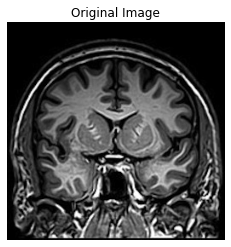

In [5]:
## Display original image
orig_fig = plt.figure()
ax = orig_fig.add_subplot(1, 1, 1)
orig_plot = plt.imshow(ORIG, cmap='gray', vmin=0, vmax=1)
ax.set_title('Original Image')
ax.axis('off')

In [6]:
## Set signal model parameters
prob = .5 							# percentage of Fourier coefficients measured
H, W = ORIG.shape[:2] 				# height and width of orig image
N = H*W 							# image dimension
sigma = 1							# noise level of measurements

## Make measurements
mask = np.random.choice([0, 1], size=(H,W), p=[1 - prob, prob])	# generate random mask
index = np.nonzero(mask)
index = np.transpose(index)

noises = np.random.normal(0, sigma, (H,W))						# generate random noise
forig = np.fft.fft2(ORIG)										# fft2 of image
y0 = np.multiply(forig, mask)									# noiseless measurements
y = y0 + noises 												# noisy measurements

## Initialize variables
x_init = np.absolute(np.fft.ifft2(y))
mintmp = np.min(x_init)
maxtmp = np.max(x_init)
x_init = (x_init - mintmp) / (maxtmp - mintmp)
x = np.copy(x_init)

(-0.5, 255.5, 255.5, -0.5)

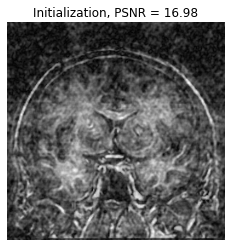

In [7]:
## Display inverse 2D-DFT of observed Fourier coefficients
init_fig = plt.figure()
ax = init_fig.add_subplot(1, 1, 1)
init_plot = plt.imshow(x_init, cmap='gray', vmin=0, vmax=1)
ax.set_title(f'Initialization, PSNR = {peak_signal_noise_ratio(x_init, ORIG):0.2f}')
ax.axis('off')

$\begin{equation}
	\textbf{PnP-SVRG}(\boldsymbol{x}_0, \eta, T_1, T_2): \\
	\text{for } s = 1, 2, . . ., T_1 \text{ do} \\
	\hspace{2ex} \tilde{\boldsymbol{x}} = \boldsymbol{x}_{s-1} \\
	\hspace{2ex} \boldsymbol{w} = \underbrace{\nabla d(\tilde{\boldsymbol{x}})}_{\text{full gradient}} \\
	\hspace{2ex} \boldsymbol{x}_0 = \tilde{\boldsymbol{x}} \\
	\hspace{2ex} \text{for } t = 1, 2, . . ., T_2 \text{ do} \\
	\hspace{4ex} \text{pick } i_t \in \{ 1, ..., m \} \text{ randomly} \\
	\hspace{4ex} \boldsymbol{v}_t = \underbrace{\nabla d_{i_t} (\boldsymbol{x}_{t-1}) - \nabla d_{i_t} (\tilde{\boldsymbol{x}}) + \boldsymbol{w}}_{\text{stochastic variance-reduced gradient}} \\
	\hspace{4ex} \boldsymbol{x}_t = \text{denoise}_\sigma (\boldsymbol{x}_{t-1} - \eta \boldsymbol{v}_t) \\
	\hspace{2ex} \text{end} \\
	\hspace{2ex} \text{set } \boldsymbol{x}_s = \boldsymbol{x}_{T_2} \\
	\text{end} \\
    \textbf{Output } \boldsymbol{x}_{T_1}
\end{equation}$

In [8]:
def PnP_SVRG_CSMRI(z, MASK, meas, eta, T1, T2, batch_size, FILTER, patch, orig):
    ## See pseudocode above
    
    ## Obtain info from inputs
    H, W = z.shape[:2] # image dimensions
    index = np.transpose(np.nonzero(MASK)) # nonzero indices of the mask
    
    ## Initialize time-keeping variables
    time_per_iter = []
    psnr_per_iter = []
    t0 = 0
    
    ## Main PnP SVRG routine
    for i in range(T1):
        # outer loop
#         eta = eta / np.sqrt(t0 + 1)
        mu = full_grad(z, MASK, meas)   	# Gradient at reference point
        w = np.copy(z) 					# Initialize reference point
        start_iter = time.time()
        for j in range(T2):
            ## inner loop
            ind = get_batch(batch_size, H, W, index) 	# Get batch index(indices) in terms of (row, col)

            ## calculate stochastic variance-reduced gradient
            v = stoch_grad(z, ind, meas) / batch_size - stoch_grad(w, ind, meas) / batch_size + mu
            ## take gradient step
            z_grad = z - eta*v

            ## Denoising
            ztilde = np.copy(z_grad)
            z = denoise_nl_means(np.real(ztilde), h=FILTER, fast_mode=True, **patch)
            
            ## Display PSNR at each iteration
            print(str(i) + " " + str(j) + " " + str(peak_signal_noise_ratio(orig, z)))

        ## Calculate time and PSNR difference per outer loop
        
        stop_iter = time.time()
        time_per_iter.append(stop_iter - start_iter)
        psnr_per_iter.append(peak_signal_noise_ratio(orig, z))

        t0 += 1
    ## Output final iterate, time keeping
    return z, time_per_iter, psnr_per_iter

In [12]:
## Run PnP-SVRG
T_outer = 100 				# Number of outer loop iterations
T_inner = 10 				# Number of inner loop iterations
eta_SVRG = .095 				# step size for SVRG
batch_size_SVRG=10000
NLM_filter = .015
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

output_SVRG, time_per_iter_SVRG, psnr_per_iter_SVRG = PnP_SVRG_CSMRI(x_init, mask, y, eta_SVRG, \
                                                                     T_outer, T_inner, batch_size_SVRG, \
                                                                     NLM_filter, patch_kw, ORIG)


0 0 17.38607929426779
0 1 17.792086236328814
0 2 18.196435033306216
0 3 18.592817690895973
0 4 18.97483503203861
0 5 19.334717144928018
0 6 19.663909753255297
0 7 19.954222319301753
0 8 20.196954673863328
0 9 20.383142789000654
1 0 20.474934828500903
1 1 20.565110278973485
1 2 20.653531414586332
1 3 20.73998937222793
1 4 20.824162822132397
1 5 20.905726999362834
1 6 20.984550768370823
1 7 21.060774645058768
1 8 21.13436067979508
1 9 21.204771833731705
2 0 21.263788313545145
2 1 21.321858640727427
2 2 21.378458963960014
2 3 21.4334777677214
2 4 21.487412934077305
2 5 21.540408519727215
2 6 21.59233615749042
2 7 21.643218973427025
2 8 21.692983808619605
2 9 21.74159794698741
3 0 21.784998203057853
3 1 21.827330751662622
3 2 21.869083774925503
3 3 21.910450497060772
3 4 21.95154117700012
3 5 21.992353918190034
3 6 22.032944860860773
3 7 22.07305668242263
3 8 22.112275816838757
3 9 22.15010116369124
4 0 22.18534974080203
4 1 22.22015385582146
4 2 22.254555551507053
4 3 22.28864238304494
4 

35 1 25.60153525584591
35 2 25.604050364792347
35 3 25.606564229785477
35 4 25.609076924804114
35 5 25.611583265093007
35 6 25.614083227289058
35 7 25.616575648532766
35 8 25.619065372244073
35 9 25.62155477460042
36 0 25.62403238165601
36 1 25.626547900420334
36 2 25.62909818224388
36 3 25.631683707097658
36 4 25.634308348807163
36 5 25.63696192551604
36 6 25.639628889108373
36 7 25.642269009643314
36 8 25.644853564482833
36 9 25.64738795694862
37 0 25.649855053292256
37 1 25.652298035444016
37 2 25.65471503862852
37 3 25.657111276014778
37 4 25.65948412413913
37 5 25.661833024332168
37 6 25.664166406916188
37 7 25.666479037068243
37 8 25.668782280348417
37 9 25.671066487219175
38 0 25.67327900354
38 1 25.675501631752073
38 2 25.6777345279176
38 3 25.67996733716071
38 4 25.682212516317303
38 5 25.684456347149805
38 6 25.686704252688898
38 7 25.68894479669961
38 8 25.691181955683994
38 9 25.693413101904138
39 0 25.695569859510613
39 1 25.697734161765467
39 2 25.69990190508986
39 3 25.7

69 9 25.741458860249775
70 0 25.741006137841637
70 1 25.740554975124013
70 2 25.740088232442254
70 3 25.73959594600796
70 4 25.739073723381996
70 5 25.73854046457309
70 6 25.737997856651976
70 7 25.737462113782875
70 8 25.736943090113428
70 9 25.73644399892672
71 0 25.736007944626206
71 1 25.735587610795754
71 2 25.735180335697976
71 3 25.7347775796312
71 4 25.734373773528468
71 5 25.733975301189172
71 6 25.733574370124572
71 7 25.733173862007504
71 8 25.73276650860635
71 9 25.73235242774626
72 0 25.731988265996428
72 1 25.73163141121478
72 2 25.73128116377756
72 3 25.73092956487197
72 4 25.73057385760069
72 5 25.73021166846509
72 6 25.729847855203904
72 7 25.729474288532078
72 8 25.7290898862018
72 9 25.728697076774417
73 0 25.7283781002499
73 1 25.728061182011995
73 2 25.72772966861737
73 3 25.727371284858464
73 4 25.726964492174453
73 5 25.726499276682894
73 6 25.725961413996508
73 7 25.725360129203665
73 8 25.724707647222157
73 9 25.724022200777547
74 0 25.723505750243135
74 1 25.7

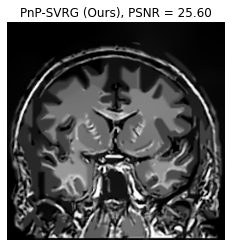

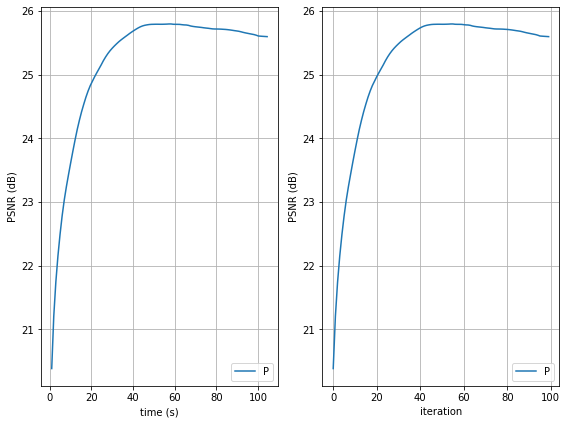

In [11]:
## Display output of PnP-SVRG algorithm
psnr_output_SVRG = peak_signal_noise_ratio(ORIG, output_SVRG)
svrg_fig = plt.figure()
ax = svrg_fig.add_subplot(1, 1, 1)
svrg_plot = plt.imshow(output_SVRG, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-SVRG (Ours), PSNR = {psnr_output_SVRG:0.2f}")
ax.axis('off')

# Figure to display iteration count/ clock time vs PSNR for all algorithms
psnr_fig, psnr_ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

psnr_ax[0].plot(np.cumsum(time_per_iter_SVRG), psnr_per_iter_SVRG)

psnr_ax[1].plot(range(np.cumsum(time_per_iter_SVRG).size), psnr_per_iter_SVRG)

psnr_ax[0].set(xlabel='time (s)', ylabel='PSNR (dB)')
psnr_ax[0].legend(('PnP-SVRG'), loc='lower right')
psnr_ax[0].grid()

psnr_ax[1].set(xlabel='iteration', ylabel='PSNR (dB)')
psnr_ax[1].legend("PnP-SVRG", loc='lower right')
psnr_ax[1].grid()

psnr_fig.tight_layout()

plt.show()

In [ ]:
## Run PnP-SVRG
T_outer = 50 				# Number of outer loop iterations
T_inner = 20 				# Number of inner loop iterations
num_trials = 4
eta_SVRG_array = np.linspace(.094, .096, num_trials)
batch_size_SVRG=10
NLM_filter = .015
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

psnr_per_trial = []
for i in range(num_trials):
    output_SVRG, time_per_iter_SVRG, psnr_per_iter_SVRG = PnP_SVRG_CSMRI(x_init, mask, y, eta_SVRG_array[i], \
                                                                     T_outer, T_inner, batch_size_SVRG, \
                                                                     NLM_filter, patch_kw, ORIG)
    psnr_per_trial.append(psnr_per_iter_SVRG[-1])

# # Figure to display iteration count/ clock time vs PSNR for all algorithms
# psnr_fig, psnr_ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

# psnr_ax[0].plot(eta_SVRG_array, psnr_per_trial)

# psnr_fig.tight_layout()

# plt.show()

svrg_fig = plt.figure()
ax = svrg_fig.add_subplot(1, 1, 1)
svrg_plot = plt.plot(eta_SVRG_array, psnr_per_trial)
ax.set_title(f"Finding Step Size")
ax.axis('on')
plt.show()

In [ ]:
## Run PnP-SVRG
T_outer = 50 				# Number of outer loop iterations
T_inner = 20 				# Number of inner loop iterations
num_trials = 10
eta_SVRG = .095
batch_size_SVRG=np.rint(np.linspace(700, 1500, num_trials)).astype(int)
NLM_filter = .015
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

psnr_per_trial = []
for i in range(num_trials):
    output_SVRG, time_per_iter_SVRG, psnr_per_iter_SVRG = PnP_SVRG_CSMRI(x_init, mask, y, eta_SVRG, \
                                                                     T_outer, T_inner, batch_size_SVRG[i], \
                                                                     NLM_filter, patch_kw, ORIG)
    psnr_per_trial.append(psnr_per_iter_SVRG[-1])

# # Figure to display iteration count/ clock time vs PSNR for all algorithms
# psnr_fig, psnr_ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

# psnr_ax[0].plot(eta_SVRG_array, psnr_per_trial)

# psnr_fig.tight_layout()

# plt.show()

svrg_fig = plt.figure()
ax = svrg_fig.add_subplot(1, 1, 1)
svrg_plot = plt.plot(batch_size_SVRG, psnr_per_trial)
ax.set_title(f"Finding Batch Size")
ax.axis('on')
plt.show()

In [ ]:
## Set signal model parameters
num_trials = 20
prob = np.linspace(0, 1, num_trials) 							# percentage of Fourier coefficients measured
H, W = ORIG.shape[:2] 				# height and width of orig image
N = H*W 							# image dimension
sigma = 1							# noise level of measurements

## Run PnP-SVRG
T_outer = 50 				# Number of outer loop iterations
T_inner = 20 				# Number of inner loop iterations
eta_SVRG = .095 				# step size for SVRG
batch_size_SVRG=1400
NLM_filter = .015
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

psnr_per_trial = []

for i in range(num_trials):
    ## Make measurements
    mask = np.random.choice([0, 1], size=(H,W), p=[1 - prob[i], prob[i]])	# generate random mask
    index = np.nonzero(mask)
    index = np.transpose(index)

    noises = np.random.normal(0, sigma, (H,W))						# generate random noise
    forig = np.fft.fft2(ORIG)										# fft2 of image
    y0 = np.multiply(forig, mask)									# noiseless measurements
    y = y0 + noises 												# noisy measurements

    ## Initialize variables
    x_init = np.absolute(np.fft.ifft2(y))
    mintmp = np.min(x_init)
    maxtmp = np.max(x_init)
    x_init = (x_init - mintmp) / (maxtmp - mintmp)
    x = np.copy(x_init)
    
    output_SVRG, time_per_iter_SVRG, psnr_per_iter_SVRG = PnP_SVRG_CSMRI(x_init, mask, y, eta_SVRG, \
                                                                     T_outer, T_inner, batch_size_SVRG, \
                                                                     NLM_filter, patch_kw, ORIG)
    psnr_per_trial.append(psnr_per_iter_SVRG[-1])
    
svrg_fig = plt.figure()
ax = svrg_fig.add_subplot(1, 1, 1)
svrg_plot = plt.plot(prob, psnr_per_trial)
ax.set_title(f"Sampling Rate vs. PSNR recovery")
ax.axis('on')
plt.show()

In [ ]:
svrg_fig = plt.figure()
ax = svrg_fig.add_subplot(1, 1, 1)
svrg_plot = plt.plot(prob, psnr_per_trial[20:40])
ax.set_title(f"Sampling Rate vs. PSNR recovery")
ax.axis('on')
plt.show()

$\begin{equation}
    \textbf{PnP-GD}(\boldsymbol{x}_0, \eta, T): \\
    \text{for } t = 1, 2, . . ., T \text{ do} \\
	\hspace{2ex} \boldsymbol{x}_t = \boldsymbol{x}_{t-1} - \eta \nabla \ell (\boldsymbol{x}_{t-1}) \\
    \hspace{2ex} \boldsymbol{x}_t = \text{denoise}_\sigma (\boldsymbol{x}_t) \\
    \text{end} \\
    \textbf{Output } \boldsymbol{x}_T
\end{equation}$


In [ ]:
def PnP_GD_CSMRI(z, MASK, meas, eta, T, FILTER, patch, orig):
    ## Obtain info from inputs
    H, W = z.shape[:2] # image dimensions
    index = np.transpose(np.nonzero(MASK)) # nonzero indices of the mask
    
    ## Initialize time-keeping variables
    time_per_iter = []
    psnr_per_iter = []
    t1 = 0
    
    # Main PnP GD routine
    for i in range(T_GD):
        start_iter = time.time()
        
        ## Gradient Update
        v = full_grad(z, mask, y)
        z = z - eta * v

        # Denoising
        ztilde = np.copy(z)
        z = denoise_nl_means(np.real(ztilde), h=FILTER, fast_mode=True, **patch)
    
        ## Log timing
        stop_iter = time.time()
        time_per_iter.append(stop_iter-start_iter)
        psnr_per_iter.append(peak_signal_noise_ratio(orig, z))

        ## Display PSNR at each iteration
        print(str(i) + " " + str(peak_signal_noise_ratio(orig, z)))
        t1 += 1
    return z, time_per_iter, psnr_per_iter

In [ ]:
T_GD = 1000
eta_GD = .8
NLM_filter = .015			 		 

patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

output_GD, time_per_iter_GD, psnr_per_iter_GD = PnP_GD_CSMRI(x_init, mask, y, eta_GD, T_GD, NLM_filter, patch_kw, ORIG)

# Figure to display iteration count/ clock time vs PSNR for all algorithms
psnr_fig, psnr_ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

psnr_ax[0].plot(np.cumsum(time_per_iter_SVRG), psnr_per_iter_SVRG)

psnr_ax[1].plot(range(np.cumsum(time_per_iter_SVRG).size), psnr_per_iter_SVRG)

psnr_ax[0].set(xlabel='time (s)', ylabel='PSNR (dB)')
psnr_ax[0].legend(('PnP-SVRG'), loc='lower right')
psnr_ax[0].grid()

psnr_ax[1].set(xlabel='iteration', ylabel='PSNR (dB)')
psnr_ax[1].legend("PnP-SVRG", loc='lower right')
psnr_ax[1].grid()

psnr_fig.tight_layout()

plt.show()

In [ ]:
## Display output of PnP-GD
psnr_output_GD = peak_signal_noise_ratio(ORIG, output_GD)
gd_fig = plt.figure()
ax = gd_fig.add_subplot(1, 1, 1)
gd_plot = plt.imshow(output_GD, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-GD, PSNR = {psnr_output_GD:0.2f}")
ax.axis('off')

$\begin{equation}
    \textbf{PnP-SGD}(\boldsymbol{x}_0, \eta, T): \\
    \text{for } t = 1, 2, . . ., T \text{ do} \\
    \hspace{2ex} \text{pick } i_t \in \{ 1, ..., m \} \text{ randomly} \\
	\hspace{2ex} \boldsymbol{x}_t = \boldsymbol{x}_{k-1} - \eta \nabla \ell_{i_t} (\boldsymbol{x}_{t-1}) \\
    \hspace{2ex} \boldsymbol{x}_t = \text{denoise}_\sigma (\boldsymbol{x}_t) \\
    \text{end} \\
    \textbf{Output } \boldsymbol{x}_T
\end{equation}$

In [ ]:
def PnP_SGD_CSMRI(z, MASK, meas, eta, T, batch_size, FILTER, patch, orig):
    ## Obtain info from inputs
    H, W = z.shape[:2] # image dimensions
    index = np.transpose(np.nonzero(MASK)) # nonzero indices of the mask
    
    ## Initialize time-keeping variables
    time_per_iter = []
    psnr_per_iter = []
    t2 = 0
    
    # Main PnP SGD routine
    for i in range(T):
        start_iter = time.time()
        # Update variables
        ind = get_batch(batch_size, H, W, index)
        v = stoch_grad(z, MASK, meas, ind)
        z = z - eta * v

        # Denoising
        ztilde = np.copy(z)
        z = denoise_nl_means(np.real(ztilde), h=FILTER, fast_mode=True, **patch)
        stop_iter = time.time()
        time_per_iter.append(stop_iter-start_iter)
        psnr_per_iter.append(peak_signal_noise_ratio(orig, z))

        print(str(i) + " " + str(peak_signal_noise_ratio(orig, z)))
        t2 += 1
    return z, time_per_iter, psnr_per_iter

In [ ]:
T_SGD = 1000
eta_SGD = 1 / L				# step size for GD
batch_size_SGD = 1000
NLM_filter = .015			 		 

patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

output_SGD, time_per_iter_SGD, psnr_per_iter_SGD = PnP_SGD_CSMRI(x_init, mask, y, eta_SGD, T_SGD, batch_size_SGD, \
                                                                 NLM_filter, patch_kw, ORIG)



In [ ]:
## Display output of PnP-SGD
psnr_output_SGD = peak_signal_noise_ratio(ORIG, output_SGD)
sgd_fig = plt.figure()
ax = sgd_fig.add_subplot(1, 1, 1)
sgd_plot = plt.imshow(output_SGD, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-SGD, PSNR = {psnr_output_SGD:0.2f}")
ax.axis('off')



(Need to rewrite code. originally taken from: https://github.com/uclaopt/Provable_Plug_and_Play and not working)

$\begin{equation}
    \textbf{PnP-ADMM}(\boldsymbol{x}_0, \boldsymbol{v}_0, \boldsymbol{u}_0, \eta, T): \\
    \text{for } t = 1, 2, . . ., T \text{ do} \\
	\hspace{2ex} \boldsymbol{x}_t = \text{prox}_d (\boldsymbol{v}_{t-1} - \boldsymbol{u}_{t-1}; \eta) \\
	\hspace{2ex} \boldsymbol{v}_t = \text{denoise}_\sigma (\boldsymbol{x}_{t} + \boldsymbol{u}_{t-1}) \\
	\hspace{2ex} \boldsymbol{u}_{t} = \boldsymbol{u}_{t-1} + (\boldsymbol{x}_{t} - \boldsymbol{v}_t) \\
    \text{end}
\end{equation}$

$\text{prox}_g (\boldsymbol{z}; \eta) \overset{\Delta}{=} {\arg\min}_{\boldsymbol{x}} \left\{ g(\boldsymbol{x}) + \frac{1}{2 \eta} \| \boldsymbol{x} - \boldsymbol{z} \|_2^2 \right\}$

In [ ]:
alpha = 2.0
T_ADMM = 20
NLM_filter = .015			 		 

x = np.copy(x_init)
print("Initial PSNR = " + str(peak_signal_noise_ratio(orig, x)))
t3 = 0

patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

time_per_iter_ADMM = []
psnr_per_iter_ADMM = []

v = np.copy(x)
u = np.zeros((H,W), dtype=np.float64)

""" Main loop. """
for i in range(T_ADMM):
    start_iter = time.time()
    xold = np.copy(x)
    vold = np.copy(v)
    uold = np.copy(u)
    """ Update variables. """

    vtilde = np.copy(x+u)
    vf = np.fft.fft2(vtilde)
    La2 = 1.0/2.0/alpha
    vf[index] = (La2 * vf[index] + y[index]) / (1.0 + La2)
    v = np.real(np.fft.ifft2(vf))

    """ Denoising step. """

    xtilde = np.copy(2*v - xold - uold)
    mintmp = np.min(xtilde)
    maxtmp = np.max(xtilde)
    xtilde = (xtilde - mintmp) / (maxtmp - mintmp)

    # the reason for the following scaling:
    # our denoisers are trained with "normalized images + noise"
    # so the scale should be 1 + O(sigma)
    scale_range = 1.0 + sigma/255.0/2.0 
    scale_shift = (1 - scale_range) / 2.0
    xtilde = xtilde * scale_range + scale_shift


    # pytorch denoising model
    x = denoise_nl_means(np.real(xtilde), h=NLM_filter, fast_mode=True, **patch_kw)

    # scale and shift the denoised image back
    x = (x - scale_shift) / scale_range
    x = x * (maxtmp - mintmp) + mintmp

    """ Update variables. """
    u = uold + xold - v
    stop_iter = time.time()

    time_per_iter_ADMM.append(stop_iter-start_iter)
    psnr_per_iter_ADMM.append(peak_signal_noise_ratio(orig, x))
    print(str(i) + " " + str(peak_signal_noise_ratio(orig, x)))
    t3 += 1

output_ADMM = np.copy(x)

In [ ]:
## Display output of PnP-ADMM
psnr_output_ADMM = peak_signal_noise_ratio(ORIG, output_ADMM)
admm_fig = plt.figure()
ax = admm_fig.add_subplot(1, 1, 1)
admm_plot = plt.imshow(output_ADMM, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-ADMM, PSNR = {psnr_output_ADMM:0.2f}")
ax.axis('off')

$\begin{equation}
	\textbf{PnP-LSVRG}(\boldsymbol{x}_0, \eta, T, p): \\
    \text{Initialize } \boldsymbol{\tilde{x}} \\
	\text{for } t = 1, 2, . . ., T \text{ do} \\
	\hspace{2ex} \boldsymbol{w} = \underbrace{\nabla d(\tilde{\boldsymbol{x}})}_{\text{full gradient}} \\
    \hspace{2ex} \text{pick } i_t \in \{ 1, ..., n \} \text{ randomly} \\
	\hspace{2ex} \boldsymbol{v}_t = \underbrace{\nabla d_{i_t} (\boldsymbol{x}_{t-1}) - \nabla d_{i_t} (\tilde{\boldsymbol{x}}) + \boldsymbol{w}}_{\text{stochastic variance-reduced gradient}} \\
	\hspace{2ex} \boldsymbol{x}_t = \text{denoise}_\sigma (\boldsymbol{x}_{t-1} - \eta \boldsymbol{v}_t) \\
	\hspace{2ex} \text{Update} \hspace{1ex} \tilde{\boldsymbol{x}} = \boldsymbol{x}_t 
\hspace{2ex} \text{ w.p. } p \\ \text{end} \\
    \textbf{Output } \boldsymbol{x}_T
\end{equation}$

In [ ]:
def PnP_LSVRG_CSMRI(z, MASK, meas, eta, T, batch_size, p, FILTER, patch, orig):
    ## Obtain info from inputs
    H, W = z.shape[:2] # image dimensions
    index = np.transpose(np.nonzero(MASK)) # nonzero indices of the mask
    
    ## Initialize time-keeping variables
    time_per_iter = []
    psnr_per_iter = []
    t4 = 0
    
    # Main PnP SVRG routine
    w = np.copy(z)
    for i in range(T):
        # outer loop
        mu = full_grad(w, MASK, meas)   	# Average gradient
        # 	w = np.copy(x) 					# reference point
        start_iter = time.time()

        # inner loop
        ind = get_batch(batch_size, H, W, index) 	# Get batch index(indices) in terms of (row, col)

        start_grad = time.time()
        v = stoch_grad(z, MASK, meas, ind) - stoch_grad(w, MASK, meas, ind) + mu
        z = z - eta*v

        # Denoising
        ztilde = np.copy(z)
        z = denoise_nl_means(np.real(ztilde), h=FILTER, fast_mode=True, **patch)

        # update reference point with probability 1-p
        if np.random.random() > p:
            w = np.copy(z)

        stop_iter = time.time()
        print(str(i) + " " + str(peak_signal_noise_ratio(orig, z)))
        time_per_iter.append(stop_iter - start_iter)
        psnr_per_iter.append(peak_signal_noise_ratio(orig, z))

        t4 += 1
    return z, time_per_iter, psnr_per_iter

In [ ]:
T_LSVRG = 10 				# Number of outer loop iterations
eta_LSVRG = 1 / L				# step size for SVRG
p_LSVRG = .2						# probability of NOT updating reference point
batch_size_LSVRG=30000
NLM_filter = .015
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

output_LSVRG, time_per_iter_LSVRG, psnr_per_iter_LSVRG = PnP_LSVRG_CSMRI(x_init, mask, y, eta_LSVRG, T_LSVRG, \
                                                                         batch_size_LSVRG, p_LSVRG, \
                                                                         NLM_filter, patch_kw, ORIG)

In [ ]:
## Display output of PnP-L-SVRG
psnr_output_LSVRG = peak_signal_noise_ratio(orig, output_LSVRG)
lsvrg_fig = plt.figure()
ax = lsvrg_fig.add_subplot(1, 1, 1)
lsvrg_plot = plt.imshow(output_LSVRG, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-L-SVRG, PSNR = {psnr_output_LSVRG:0.2f}")
ax.axis('off')

(not yet working, need to learn how to choose parameters)

$\begin{equation}
	\textbf{PnP-LKatyusha}(\theta_1, \theta_2, p \in (0, 1], T): \\
    \text{Initialize } \boldsymbol{y}_0 = \boldsymbol{w}_0 = \boldsymbol{z}_0 \in \mathbb{R}^n, \text{ stepsize } \eta = \frac{\theta_2}{(1 + \theta_2) \theta_1} \text{ and set } \sigma = \frac{\mu}{L}\\
	\text{for } t = 1, 2, . . ., T \text{ do} \\
	\hspace{2ex} \boldsymbol{x}_t = \theta_1 \boldsymbol{z}_t + \theta_2 \boldsymbol{w}_t + (1 - \theta_1 - \theta_2) \boldsymbol{y}_k \\
    \hspace{2ex} \text{pick } i_t \in \{ 1, ..., n \} \text{ randomly} \\
	\hspace{2ex} \boldsymbol{g}_t = \nabla \ell_i (\boldsymbol{x}_t) - \nabla_i \ell_i (\boldsymbol{w}_t) + \nabla \ell (\boldsymbol{w}_t) \\
	\hspace{2ex} \boldsymbol{z}_{t+1} = \frac{1}{1 + \eta \sigma} (\eta \sigma \boldsymbol{x}_t + \boldsymbol{z}_t - \frac{\eta}{L} \boldsymbol{g}_t) \\
    \hspace{2ex} \boldsymbol{y}_{t+1} = \boldsymbol{x} + \theta_1 (\boldsymbol{z}_{t+1} - \boldsymbol{z}_t) \\
	\hspace{2ex} \text{Update} \hspace{1ex} \boldsymbol{w}_{t+1} = \boldsymbol{y}_t
\hspace{2ex} \text{ w.p. } p \\ \text{end} \\
    \textbf{Output } \boldsymbol{x}_T
\end{equation}$

In [ ]:
T_LKatyusha = 10 				# Number of outer loop iterations

p = .2						# probability of NOT updating reference point
theta1 = .1
theta2 = .1
eta_LKatyusha = theta2/((1+theta2)*theta1)				# step size for SVRG
mu = 1
L = 1
sigma = mu/L

batch_size_LKatyusha=30000
NLM_filter = .015
patch_kw = dict(patch_size=5,      # 5x5 patches
                patch_distance=6,  # 13x13 search area
                multichannel=True)

time_per_iter_LKatyusha = []
psnr_per_iter_LKatyusha = []

y = np.copy(x_init)
w = np.copy(x_init)
z = np.copy(x_init)

t5 = 0
# Main PnP SVRG routine
for i in range(T_LKatyusha):
    z_old = np.copy(z)
    x = theta1*z + theta2*w + (1 - theta1 - theta2)*y
    start_iter = time.time()

    # inner loop
    ind = get_batch(batch_size_LKatyusha, H, W, index) 	# Get batch index(indices) in terms of (row, col)

    start_grad = time.time()
    g = stoch_grad(x, mask, y, ind) - stoch_grad(w, mask, y, ind) + full_grad(w, mask, y)
    z = (1 / (1 + eta_LKatyusha*sigma))*(eta_LKatyusha*sigma*x + z - eta_LKatyusha / L * g)
    y = x + theta1*(z - z_old)
    
    # Denoising
    wtilde = np.copy(w)

    # denoise
    w = denoise_nl_means(np.real(wtilde), h=NLM_filter, fast_mode=True, **patch_kw)
    print(str(i) + " " + str(peak_signal_noise_ratio(orig, w)))

    # update reference point with probability 1-p
    if np.random.random() > p:
        w = np.copy(y)
        
    stop_iter = time.time()
    time_per_iter_LKatyusha.append(stop_iter - start_iter)
    psnr_per_iter_LKatyusha.append(peak_signal_noise_ratio(orig, w))

    t5 += 1
output_LKatyusha = w

In [ ]:
## Display output of PnP-L-Katyusha
psnr_output_LKatyusha = peak_signal_noise_ratio(orig, output_LKatyusha)
lkatyusha_fig = plt.figure()
ax = lkatyusha_fig.add_subplot(1, 1, 1)
lkatyusha_plot = plt.imshow(output_LKatyusha, cmap='gray', vmin=0, vmax=1)
ax.set_title(f"PnP-L-Katyusha, PSNR = {psnr_output_LKatyusha:0.2f}")
ax.axis('off')

In [ ]:
# Figure to display iteration count/ clock time vs PSNR for all algorithms
psnr_fig, psnr_ax = plt.subplots(nrows=1, ncols=2, figsize=(8, 6))

psnr_ax[0].plot(np.cumsum(time_per_iter_SVRG), psnr_per_iter_SVRG)
psnr_ax[0].plot(np.cumsum(time_per_iter_GD), psnr_per_iter_GD)
psnr_ax[0].plot(np.cumsum(time_per_iter_SGD), psnr_per_iter_SGD)
psnr_ax[0].plot(np.cumsum(time_per_iter_ADMM), psnr_per_iter_ADMM)
psnr_ax[0].plot(np.cumsum(time_per_iter_LSVRG), psnr_per_iter_LSVRG)
psnr_ax[0].plot(np.cumsum(time_per_iter_LKatyusha), psnr_per_iter_LKatyusha)

psnr_ax[1].plot(range(t0), psnr_per_iter_SVRG)
psnr_ax[1].plot(range(t1), psnr_per_iter_GD)
psnr_ax[1].plot(range(t2), psnr_per_iter_SGD)
psnr_ax[1].plot(range(t3), psnr_per_iter_ADMM)
psnr_ax[1].plot(range(t4), psnr_per_iter_LSVRG)
psnr_ax[1].plot(range(t5), psnr_per_iter_LKatyusha)

psnr_ax[0].set(xlabel='time (s)', ylabel='PSNR (dB)')
psnr_ax[0].legend(('PnP-SVRG', 'PnP-GD', 'PnP-SGD', 'PnP-ADMM', 'PnP-LSVRG', 'PnP-LKatyusha'), loc='lower right')
psnr_ax[0].grid()

psnr_ax[1].set(xlabel='iteration', ylabel='PSNR (dB)')
psnr_ax[1].legend(('PnP-SVRG','PnP-GD', 'PnP-SGD', 'PnP-ADMM', 'PnP-LSVRG', 'PnP-LKatyusha'), loc='lower right')
psnr_ax[1].grid()

psnr_fig.tight_layout()

plt.show()